In [1]:
import scipy
import numpy as np
from matplotlib import pyplot as plt
from playsound import playsound

In [2]:
""" Signal parameters """
fs = 48000
n_sec = 10
amplitude = np.iinfo(np.int16).max

""" Plot parameters """
figsize = (3.2, 2.4)

In [9]:
def periodogram(x, N=2**20, Fs=fs):
    sp = scipy.fft.fftshift(scipy.fft.fft(x=x, n=N))
    freq = scipy.fft.fftshift(scipy.fft.fftfreq(n=N, d=1/Fs))
    Pxx = np.abs(sp)**2 / N
    return freq, Pxx

def periodogram_averaging(x, N, L, D):
    periodograms = []
    i = 0
    while i < (N-D):
        window = scipy.signal.windows.tukey(L, alpha=0.5, sym=True)
        data = x[i:i+L]
        data_windowed = np.multiply(window, data)
        freq, Pxx = periodogram(x=data_windowed, N=L)
        periodograms.append(Pxx)
        i = i + L - D
    K = len(periodograms)
    y = np.array([np.array(xi) for xi in periodograms])
    mean_periodogram = np.mean(a=y, axis=0)
    return freq, mean_periodogram, K

Square wave

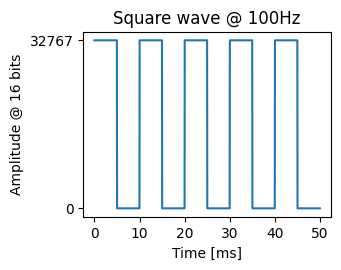

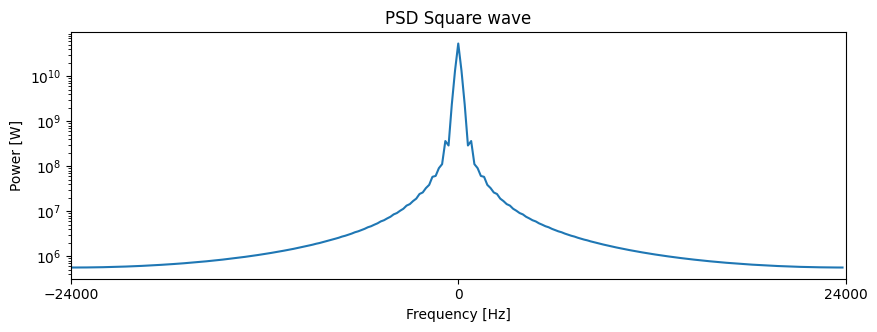

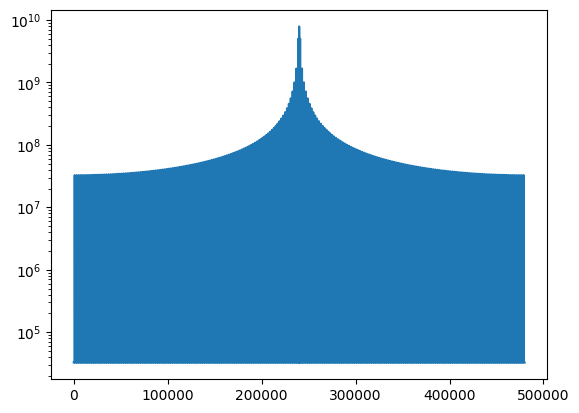

In [45]:
f = 100
t = np.linspace(start=0, stop=n_sec, num=n_sec*fs)
x = amplitude//2 *( 1 + scipy.signal.square(2 * np.pi * f * t) )
scipy.io.wavfile.write("recordings/square_wave_minus.wav", fs, x.astype(np.int16))

plt.figure(num="Square wave", figsize=figsize)
plt.plot(t[:fs//20], x[:fs//20])
plt.title(f"Square wave @ {f}Hz")
plt.xticks(ticks=[0, 10e-3, 20e-3, 30e-3, 40e-3, 50e-3], labels=[0,10,20,30,40,50])
plt.xlabel("Time [ms]")
plt.yticks(ticks=[0, 2**15-1])
plt.ylabel("Amplitude @ 16 bits")
plt.show()


# Periodograma
N = len(x)
L = N // 2000
freq, Pxx, K = periodogram_averaging(x=x, N=N, L=L, D=L//2)
plt.figure(figsize=(10,3.2))
plt.semilogy(freq, Pxx)
plt.title("PSD Square wave")
plt.xlim((-fs//2, fs//2))
plt.xticks(ticks=[-fs//2, 0, fs//2])
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power [W]")
plt.show()

plt.figure()
plt.semilogy(np.abs(scipy.fft.fftshift(scipy.fft.fft(x))))
plt.show()

Barrido lineal en frecuencia

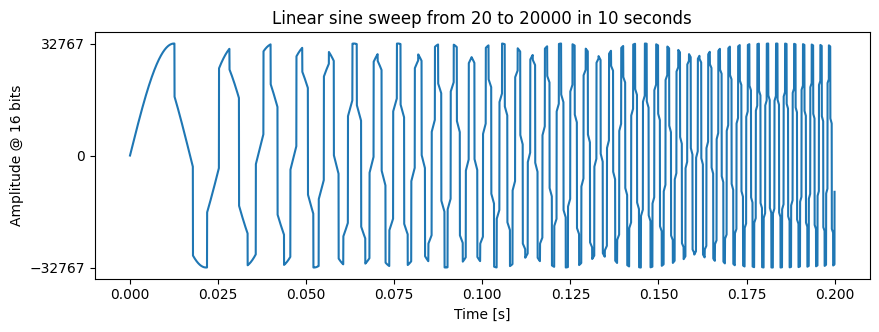

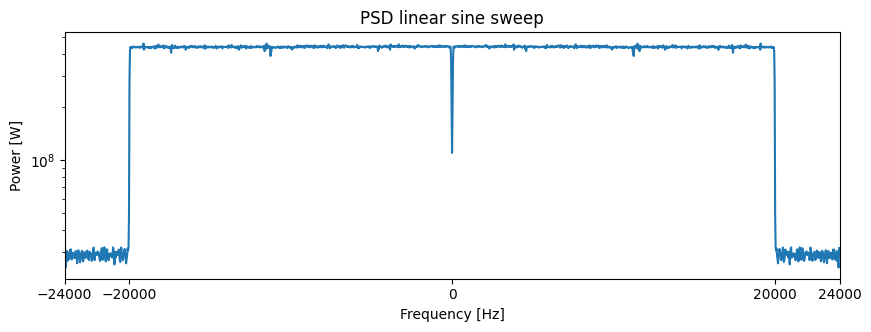

In [63]:
f0 = 20
f1 = 20000
T = n_sec
k = (f1 - f0) / T
t = np.linspace(start=0, stop=n_sec, num=n_sec*fs)
x = np.iinfo(np.int16).max * np.sin( 2*np.pi*f0*t + 2*np.pi*k*t**2//2  )
scipy.io.wavfile.write("recordings/linear_sine_sweep.wav", fs, x.astype(np.int16))

plt.figure(num="Line sine sweep", figsize=(10, 3.2))
plt.plot(t[:fs//5], x[:fs//5])
plt.title(f"Linear sine sweep from {f0} to {f1} in {T} seconds")
plt.xlabel("Time [s]")
plt.yticks(ticks=[-2**15, 0, 2**15-1])
plt.ylabel("Amplitude @ 16 bits")
plt.show()


# Periodograma
N = len(x)
L = N // 300
freq, Pxx, K = periodogram_averaging(x=x, N=N, L=L, D=L//2)
plt.figure(figsize=(10,3.2))
plt.semilogy(freq, Pxx)
plt.title("PSD linear sine sweep")
plt.xlim((-fs//2, fs//2))
plt.xticks(ticks=[-fs//2, -20000, 0, 20000, fs//2])
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power [W]")
plt.show()

Barrido exponencial en frecuencia

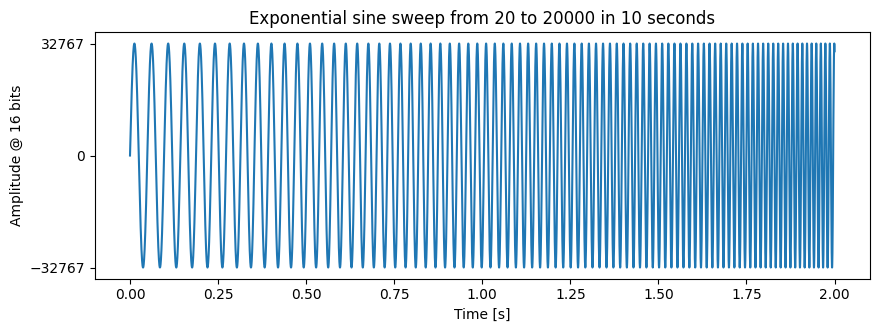

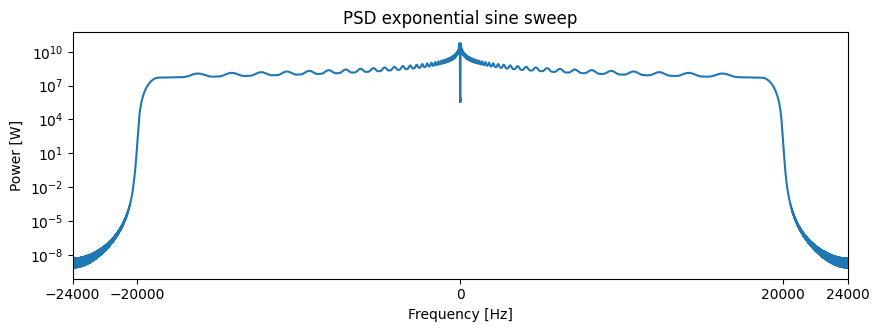

In [69]:
f0 = 20
f1 = 20000
T = n_sec
k = (f1 / f0) ** (1 / T)
t = np.linspace(start=0, stop=n_sec, num=n_sec*fs)
x = np.iinfo(np.int16).max * np.sin( 2*np.pi*f0 * (k**t - 1) / (np.log(k)) )
scipy.io.wavfile.write("recordings/exp_sine_sweep.wav", fs, x.astype(np.int16))

plt.figure(num="Exponential sine sweep", figsize=(10, 3.2))
plt.plot(t[:2*fs], x[:2*fs])
plt.title(f"Exponential sine sweep from {f0} to {f1} in {T} seconds")
plt.xlabel("Time [s]")
plt.yticks(ticks=[-2**15, 0, 2**15-1])
plt.ylabel("Amplitude @ 16 bits")
plt.show()

# Periodograma
N = len(x)
L = N // 25
freq, Pxx, K = periodogram_averaging(x=x, N=N, L=L, D=L//2)
plt.figure(figsize=(10,3.2))
plt.semilogy(freq, Pxx)
plt.title("PSD exponential sine sweep")
plt.xlim((-fs//2, fs//2))
plt.xticks(ticks=[-fs//2, -20000, 0, 20000, fs//2])
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power [W]")
plt.show()

Ruido blanco gaussiano de media cero

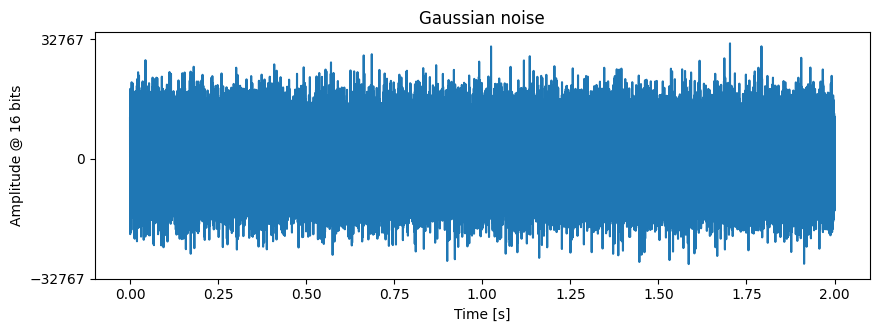

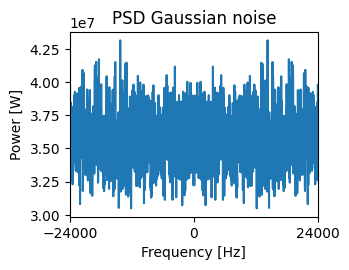

In [72]:
t = np.linspace(start=0, stop=n_sec, num=n_sec*fs)
x = np.random.normal(loc=0, scale=1, size=n_sec*fs)
x = amplitude * x / np.max(x)
scipy.io.wavfile.write("recordings/gaussian_noise.wav", fs, x.astype(np.int16))

plt.figure(num="Gaussian noise", figsize=(10, 3.2))
plt.plot(t[:2*fs], x[:2*fs])
plt.title(f"Gaussian noise")
plt.xlabel("Time [s]")
plt.yticks(ticks=[1-2**15, 0, 2**15-1])
plt.ylabel("Amplitude @ 16 bits")
plt.show()


# Periodograma
N = len(x)
L = N // 200
freq, Pxx, K = periodogram_averaging(x=x, N=N, L=L, D=L//2)
plt.figure(figsize=figsize)
plt.plot(freq, Pxx)
plt.title("PSD Gaussian noise")
plt.xlim((-fs//2, fs//2))
plt.xticks(ticks=[-fs//2, 0, fs//2])
plt.xlabel("Frequency [Hz]")
#plt.ylim((0,10**8))
plt.ylabel("Power [W]")
plt.show()

In [ ]:
np.var(x)

53316339.54451772